# <font color = 'color'>블록 딥러닝: 7장.음악시퀀스 예측_심층신경망(DNN) 이용</font>

# <font color = 'blue'>문제 정의</font>

### 나비야 노래음표 데이터셋(Naviya Musical Notes Dataset)
* 다중분류(multi-class classification) 문제
* 노래를 구성하고 있는 음표 구성 특성에 따라 이어지는 노래 음표시퀀스를 분류예측하는 문제
* 기존 로이터뉴스 예제는 텍스트 시퀀스 데이터를 분석해서 최종적인 뉴스기사의 주제를 분류예측을 해보는 문제였음: n to 1 예측문제
* 이번 문제는 음표 시퀀스 데이터를 분석해서 일정 윈도우 길이마다 시퀀스로 분류예측을 하는 문제임: n to n 예측문제
<img src = './../../images/naviya.png'>

1. 피처(입력/예측/독립)변수
    * 한 편의 노래를 구성하고 있는 음표코드별 인덱스번호를 4개 단위로 만들어 순서대로 나열한 데이터 <pre>
1. 타깃(출력/반응/종속)변수
    * 4개 음표 인덱스 번호가 입력되었을 때 예측될 음표 인덱스 번호
<img src = './../../images/naviya_prediction.png'>

4개씩 학습한 다음에 5번째 데이터를 target변수(= y값)로 둬서 예측


# <font color = 'blue'>데이터 준비</font>

### 시각화 모듈로딩 및 한글폰트 작업

In [1]:
# 시각화 작업을 위한 모듈 로딩작업
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

In [2]:
# 사용을 원하는 한글폰트에 대한 공식이름 확인
font_name = font_manager.FontProperties(fname="./fonts/malgun.ttf").get_name()
print(font_name)

font_name = font_manager.FontProperties(fname="./fonts/NanumGothic.ttf").get_name()
print(font_name)

# 해당 한글폰트를 파이선 그래프에서 사용가능하도록 설정
plt.rcParams["font.family"] = font_name
plt.rcParams['axes.unicode_minus'] = False

Malgun Gothic
NanumGothic


In [3]:
# 워닝메시지 출력관련 모듈로딩
import warnings

warnings.filterwarnings(action = 'ignore') 
# - 출력되는 경고메시지를 무시하고 숨김

# warnings.filterwarnings(action = 'default')
# - 다시 경고메시지가 나타나도록 함

### 기본 라이브러리 로딩

In [4]:
# 기본 범용라이브러리 로딩
import numpy as np
import pandas as pd
import os, shutil

# <font color = 'blue'>데이터 준비</font>

### 분석대상 음표 raw 데이터 준비

In [5]:
seq = ["g8", "e8", "e4", "f8", "d8", "d4", "c8", "d8", "e8", "f8", "g8", "g8", "g4", 
       "g8", "e8", "e8", "e8", "f8", "d8", "d4", "c8", "e8", "g8", "g8", "e8", "e8", "e4", 
       "d8", "d8", "d8", "d8", "d8", "e8", "f4", "e8", "e8", "e8", "e8", "e8", "f8", "g4", 
       "g8", "e8", "e4", "f8", "d8", "d4", "c8", "e8", "g8", "g8", "e8", "e8", "e4"] 
print(seq)

['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


### 음표사전 만들기

In [6]:
# 음표코드to음표번호 사전(code2idx)
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6, 
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}
code2idx

{'c4': 0,
 'd4': 1,
 'e4': 2,
 'f4': 3,
 'g4': 4,
 'a4': 5,
 'b4': 6,
 'c8': 7,
 'd8': 8,
 'e8': 9,
 'f8': 10,
 'g8': 11,
 'a8': 12,
 'b8': 13}

In [7]:
# 음표번호to음표코드 사전(idx2code) -> 디코딩 목적(컴퓨터의 숫자를 우리가 알아볼 수 있도록)
# 하나하나 입력하기보다는 dictionary reversing 을 하면됨.  for문 돌려서 key를 value에 value를 key에 넣어주면 됨
idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4', 
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}
idx2code

{0: 'c4',
 1: 'd4',
 2: 'e4',
 3: 'f4',
 4: 'g4',
 5: 'a4',
 6: 'b4',
 7: 'c8',
 8: 'd8',
 9: 'e8',
 10: 'f8',
 11: 'g8',
 12: 'a8',
 13: 'b8'}

In [8]:
# 개별 뉴스의 단어인덱스번호를 이용한 실제 단어명 구성내용 확인
# - for 구문에 print() 함수이용
# - 딕셔너리.get(key값) => values값이 나옴

seq_num = []

for i in seq:
    seq_num.append(code2idx.get(i)) # 음표기호를 숫자기호로 변형되게 seq_num리스트에 하나씩 추가

print(seq_num)

[11, 9, 2, 10, 8, 1, 7, 8, 9, 10, 11, 11, 4, 11, 9, 9, 9, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2, 8, 8, 8, 8, 8, 9, 3, 9, 9, 9, 9, 9, 10, 4, 11, 9, 2, 10, 8, 1, 7, 9, 11, 11, 9, 9, 2]


N2N예측 입력도 다중, 출력도 다중
<br><br>

### 원하는 음표길이(갯수)만큼 시퀀스 데이터셋 만들기 

#### 음표시퀀스 전체데이터를 4개 음표단위로 분할해 시퀀스 데이터셋을 만들기

In [9]:
print('음표시퀀스 전체 데이터 길이:', len(seq))

window_size = 4
print('음표시퀀스 추출 윈도우 길이:', window_size)

음표시퀀스 전체 데이터 길이: 54
음표시퀀스 추출 윈도우 길이: 4


4개 윈도우를 슬라이드 기법으로 음표를 옮기는 것. (자르는게 아님) <br>
1,2,3,4 -> 5 예측 <br>
2,3,4,5 -> 6 예측 <br>
3,4,5,6 -> 7 예측 이런식으로 음표를 한칸씩 옮겨가면서 촘촘히 예측함 <br>
4개 데이터는 feature set, 5번째 데이터는 target set

In [10]:
# 음표시퀀스 데이터셋 저장용 리스트객체 생성 
dataset = []

# for반복구문을 이용한 시퀀스 데이터셋을 분리추출
for i in range(len(seq) - window_size): # 5부터 54까지 50번의 for문을 돌겠지
    
    subset = seq[i:(i + window_size + 1)]
    # - 전체 음표시퀀스 데이터에서 원하는 윈도우 길이 + 1 만큼 부분추출
    # - 윈도우 길이만큼의 음표로 학습을 하고, 이어진 + 1에 해당하는 음표를 분류예측하는 학습을 진행하게 됨
    
    dataset.append([code2idx[item] for item in subset])
    # - 음표코드2인덱스번호 사전을 이용해 분리추출한 
    #   음표 하나하나를 인덱스번호로 변환해 데이터셋을 만듬
    
dataset = np.asarray(dataset)

In [11]:
# 윈도우 길이만큼 분리 추출된 음표시퀀스 데이터셋 객체유형과 구조
print('음표시퀀스 데이터셋 객체유형:', type(dataset))
print('음표시퀀스 데이터셋 객체구조:', dataset.shape)

print()

# 윈도우 길이만큼 분리추출된 음표 데이터셋
print('음표시퀀스 데이터셋 내용:\n', dataset)

음표시퀀스 데이터셋 객체유형: <class 'numpy.ndarray'>
음표시퀀스 데이터셋 객체구조: (50, 5)

음표시퀀스 데이터셋 내용:
 [[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


위의 데이터를 잘 보면, <br>
[1,2,3,4,5] <br> 
[2,3,4,5,6] <br>
[3,4,5,6,7] <br>
[4,5,6,7,8] <br>

이런식으로 음표를 한칸씩 옮겨가면서 데이터셋을 저장해놓은 것을 볼 수 있다.

#### 음표시퀀스 데이터셋 생성을 위한 사용자정의함수 만들기 

In [12]:
# 원하는 윈도우 길이만큼 부분추출 음표 데이터셋을 만들어 주는 사용자정의함수 생성
def seq2dataset(seq, window_size):

    # 음표시퀀스 데이터셋 저장용 리스트객체 생성 
    dataset = []

    # for반복구문을 이용한 시퀀스 데이터셋을 분리추출
    for i in range(len(seq) - window_size):

        subset = seq[i:(i + window_size + 1)]
        # - 전체 음표시퀀스 데이터에서 원하는 윈도우 길이 + 1 만큼 부분추출
        # - 윈도우 길이만큼의 음표로 학습을 하고, 이어진 + 1에 해당하는 음표를 분류예측하는 학습을 진행하게 됨

        dataset.append([code2idx[item] for item in subset])
        # - 음표코드2인덱스번호 사전을 이용해 분리추출한 
        #   음표 하나하나를 인덱스번호로 변환해 데이터셋을 만듬
     
    # 사용자정의함수 반환값 지정
    return np.array(dataset)

In [13]:
# 메모리상에서 사용자정의함수 생성여부 확인 
%whos

Variable       Type        Data/Info
------------------------------------
code2idx       dict        n=14
dataset        ndarray     50x5: 250 elems, type `int32`, 1000 bytes
font_manager   module      <module 'matplotlib.font_<...>lotlib\\font_manager.py'>
font_name      str         NanumGothic
i              int         49
idx2code       dict        n=14
np             module      <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os             module      <module 'os' from 'C:\\Anaconda3\\lib\\os.py'>
pd             module      <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt            module      <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
seq            list        n=54
seq2dataset    function    <function seq2dataset at 0x0000018595DF6598>
seq_num        list        n=54
shutil         module      <module 'shutil' from 'C:<...>aconda3\\lib\\shutil.py'>
sns            module      <module 'seaborn' from 'C<...>s\\seaborn\\__init__.py'>
subset         l

In [14]:
dataset = seq2dataset(seq, window_size = 4)

In [15]:
# 사용자정의함수를 통해 추출된 음표시퀀스 데이터셋 구조
print('음표시퀀스 데이터셋 객체유형:', type(dataset))
print('음표시퀀스 데이터셋 객체구조:', dataset.shape)

print()

# 윈도우 길이만큼 분리추출된 음표 데이터셋
print('음표시퀀스 데이터셋 내용:\n', dataset)

음표시퀀스 데이터셋 객체유형: <class 'numpy.ndarray'>
음표시퀀스 데이터셋 객체구조: (50, 5)

음표시퀀스 데이터셋 내용:
 [[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


가중치와 bias를 통해 y값을 만들어내야하는데  <br>
현재, 음악 코드가 인덱스번호(숫자)이기 때문에 동일한 조건으로 판단 안 할 가능성이 크다. <br>
그러므로 독립변수 4자리는 0과 1사이로 스케일링을 해줘야함

### 음표시퀀스 데이터셋 분할: 피처셋과 타겟변수

In [16]:
# 훈련용 피처셋 추출
X_train = dataset[:, 0:4]

print('훈련용 피처셋 객체유형:', type(X_train))
print('훈련용 피처셋 객체규모:', X_train.shape)

# 훈련용 타겟변수 추출
y_train = dataset[:, 4]

print('훈련용 타겟변수 객체유형:', type(y_train))
print('훈련용 타겟변수 객체규모:', y_train.shape)

훈련용 피처셋 객체유형: <class 'numpy.ndarray'>
훈련용 피처셋 객체규모: (50, 4)
훈련용 타겟변수 객체유형: <class 'numpy.ndarray'>
훈련용 타겟변수 객체규모: (50,)


# <font color = 'blue'>데이터 탐색</font>

### 훈련용 음표 피처셋 탐색

In [17]:
# 훈련 데이터셋 중 피처셋 음표 인덱스번호 내용조회

X_train
# - 4개의 시퀀스 음표 인덱스번호가 훈련용 피처셋으로 입력될 예정

array([[11,  9,  2, 10],
       [ 9,  2, 10,  8],
       [ 2, 10,  8,  1],
       [10,  8,  1,  7],
       [ 8,  1,  7,  8],
       [ 1,  7,  8,  9],
       [ 7,  8,  9, 10],
       [ 8,  9, 10, 11],
       [ 9, 10, 11, 11],
       [10, 11, 11,  4],
       [11, 11,  4, 11],
       [11,  4, 11,  9],
       [ 4, 11,  9,  9],
       [11,  9,  9,  9],
       [ 9,  9,  9, 10],
       [ 9,  9, 10,  8],
       [ 9, 10,  8,  1],
       [10,  8,  1,  7],
       [ 8,  1,  7,  9],
       [ 1,  7,  9, 11],
       [ 7,  9, 11, 11],
       [ 9, 11, 11,  9],
       [11, 11,  9,  9],
       [11,  9,  9,  2],
       [ 9,  9,  2,  8],
       [ 9,  2,  8,  8],
       [ 2,  8,  8,  8],
       [ 8,  8,  8,  8],
       [ 8,  8,  8,  8],
       [ 8,  8,  8,  9],
       [ 8,  8,  9,  3],
       [ 8,  9,  3,  9],
       [ 9,  3,  9,  9],
       [ 3,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 9,  9,  9,  9],
       [ 9,  9,  9, 10],
       [ 9,  9, 10,  4],
       [ 9, 10,  4, 11],
       [10,  4, 11,  9],


In [18]:
# 훈련 데이터셋 중 피처셋 음표 인덱스번호 내용을 1차원 배열로 재구조화

X_train_1d = X_train.reshape(-1)
X_train_1d
# - 어떠한 음표 인덱스번호가 많이 사용되었는지를 보기 위해서
#   자료구조를 1차원 배열로 만들어서 인덱스 번호숫자별 카운팅을 하기 위함

array([11,  9,  2, 10,  9,  2, 10,  8,  2, 10,  8,  1, 10,  8,  1,  7,  8,
        1,  7,  8,  1,  7,  8,  9,  7,  8,  9, 10,  8,  9, 10, 11,  9, 10,
       11, 11, 10, 11, 11,  4, 11, 11,  4, 11, 11,  4, 11,  9,  4, 11,  9,
        9, 11,  9,  9,  9,  9,  9,  9, 10,  9,  9, 10,  8,  9, 10,  8,  1,
       10,  8,  1,  7,  8,  1,  7,  9,  1,  7,  9, 11,  7,  9, 11, 11,  9,
       11, 11,  9, 11, 11,  9,  9, 11,  9,  9,  2,  9,  9,  2,  8,  9,  2,
        8,  8,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  8,  8,  9,  3,  8,  9,  3,  9,  9,  3,  9,  9,  3,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,  9,  9, 10,  4,  9,
       10,  4, 11, 10,  4, 11,  9,  4, 11,  9,  2, 11,  9,  2, 10,  9,  2,
       10,  8,  2, 10,  8,  1, 10,  8,  1,  7,  8,  1,  7,  9,  1,  7,  9,
       11,  7,  9, 11, 11,  9, 11, 11,  9, 11, 11,  9,  9])

In [19]:
# 훈련용 데이터셋 중 피처셋 음표 인덱스번호 최소값
print('피처셋 음표 인덱스번호 최소값:', np.min(X_train_1d))

# 훈련용 데이터셋 중 피처셋 음표 인덱스번호 최대값
print('피처셋 음표 인덱스번호 최대값:', np.max(X_train_1d))

피처셋 음표 인덱스번호 최소값: 1
피처셋 음표 인덱스번호 최대값: 11


In [20]:
# 훈련 데이터셋 중 피처셋 음표 인덱스번호 파악
X_train_uq = np.unique(X_train_1d)
print('피처셋 음표유형 인덱스번호:\n', X_train_uq)

X_train_bin = np.bincount(X_train_1d)
print('\n피처셋  음표 인덱스번호별 빈도수:\n', X_train_bin)

X_train_por = [round(i / sum(X_train_bin), 3) for i in X_train_bin]
print('\n피처셋  음표 인덱스번호별 비율:\n', X_train_por)

피처셋 음표유형 인덱스번호:
 [ 1  2  3  4  7  8  9 10 11]

피처셋  음표 인덱스번호별 빈도수:
 [ 0 12 11  4  8  0  0 12 36 65 20 32]

피처셋  음표 인덱스번호별 비율:
 [0.0, 0.06, 0.055, 0.02, 0.04, 0.0, 0.0, 0.06, 0.18, 0.325, 0.1, 0.16]


In [21]:
# collections 모듈을 이용한 피처셋 음표 인덱스번호 유형과 빈도수 동시 계산
import collections

# 훈련 데이터셋 중 피처셋 음표 인덱스번호별 빈도수
X_train_dic = collections.Counter(X_train_1d)
print('피처셋 음표 인덱스번호와 빈도수 딕셔너리:\n', X_train_dic)

피처셋 음표 인덱스번호와 빈도수 딕셔너리:
 Counter({9: 65, 8: 36, 11: 32, 10: 20, 1: 12, 7: 12, 2: 11, 4: 8, 3: 4})


In [22]:
# 훈련 데이터셋 중 피처셋 딕셔너리 소팅
X_train_odic = collections.OrderedDict(sorted(X_train_dic.items()))
X_train_odic

OrderedDict([(1, 12),
             (2, 11),
             (3, 4),
             (4, 8),
             (7, 12),
             (8, 36),
             (9, 65),
             (10, 20),
             (11, 32)])

In [23]:
# 훈련 데이터셋 중 피처셋 음표 인덱스번호 조회
print('피처셋 음표 인덱스번호 조회:\n', list(X_train_odic.keys()))

# 훈련 데이터셋 중 피처셋 음표 인덱스번호별 음표유형 조회
print('\n피처셋 음표 인덱스번호별 음표유형 조회:\n', [idx2code.get(i) for i in list(X_train_odic.keys())])

# 훈련 데이터셋 중 피처셋음표 인덱스번호별 빈도수 조회
print('\n피처셋 음표 인덱스번호별 빈도수 조회:\n', list(X_train_odic.values()))

X_train_por = [round(i / sum(X_train_odic.values()), 3) for i in X_train_odic.keys()]
print('\n피처셋 음표 인덱스번호별 비율:\n', X_train_por)

피처셋 음표 인덱스번호 조회:
 [1, 2, 3, 4, 7, 8, 9, 10, 11]

피처셋 음표 인덱스번호별 음표유형 조회:
 ['d4', 'e4', 'f4', 'g4', 'c8', 'd8', 'e8', 'f8', 'g8']

피처셋 음표 인덱스번호별 빈도수 조회:
 [12, 11, 4, 8, 12, 36, 65, 20, 32]

피처셋 음표 인덱스번호별 비율:
 [0.005, 0.01, 0.015, 0.02, 0.035, 0.04, 0.045, 0.05, 0.055]


In [24]:
# 훈련 데이터셋 중 피처셋 음표별 분포테이블
X_train_tb = pd.DataFrame({'idx': list(X_train_odic.keys()), 
                           'code': [ idx2code.get(i) for i in list(X_train_odic.keys())],
                           'frequency': list(X_train_odic.values()), 
                           'oportion': X_train_por})
X_train_tb

,idx,code,frequency,oportion
0,1,d4,12,0.005
1,2,e4,11,0.010
2,3,f4,4,0.015
3,4,g4,8,0.020
4,7,c8,12,0.035
5,8,d8,36,0.040
6,9,e8,65,0.045
7,10,f8,20,0.050
8,11,g8,32,0.055


In [25]:
# 어떤 음표가 많은지 발생빈도(frequency) 순으로 내림차순 정렬
X_train_tb_sorted = X_train_tb.sort_values('frequency', ascending = 0).reset_index(drop = True) 
X_train_tb_sorted

,idx,code,frequency,oportion
0,9,e8,65,0.045
1,8,d8,36,0.040
2,11,g8,32,0.055
3,10,f8,20,0.050
4,1,d4,12,0.005
5,7,c8,12,0.035
6,2,e4,11,0.010
7,4,g4,8,0.020
8,3,f4,4,0.015


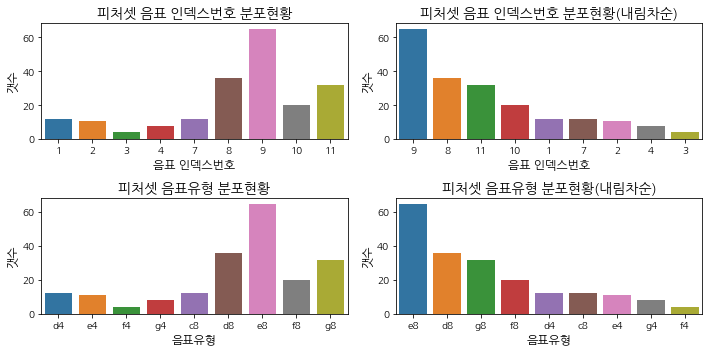

In [26]:
# 훈련 데이터셋 중 피처셋 음표 분포그래프
fig = plt.figure(figsize = (10, 5))

plt.subplot(2, 2, 1)
ax = sns.barplot(x = 'idx', y = 'frequency', data = X_train_tb) 
ax.set_title('피처셋 음표 인덱스번호 분포현황', size = 14) 
ax.set_xlabel('음표 인덱스번호', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 2)
ax = sns.barplot(x = 'idx', y = 'frequency', data = X_train_tb_sorted, 
                order = X_train_tb_sorted.idx.values) 
ax.set_title('피처셋 음표 인덱스번호 분포현황(내림차순)', size = 14) 
ax.set_xlabel('음표 인덱스번호', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 3)
ax = sns.barplot(x = 'code', y = 'frequency', data = X_train_tb) 
ax.set_title('피처셋 음표유형 분포현황', size = 14) 
ax.set_xlabel('음표유형', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 4)
ax = sns.barplot(x = 'code', y = 'frequency', data = X_train_tb_sorted, 
                order = X_train_tb_sorted.code.values) 
ax.set_title('피처셋 음표유형 분포현황(내림차순)', size = 14) 
ax.set_xlabel('음표유형', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.tight_layout()

### 훈련용 음표 타겟변수 탐색

In [27]:
# 훈련 데이터셋 중 타겟변수 음표 인덱스번호 내용조회

y_train

array([ 8,  1,  7,  8,  9, 10, 11, 11,  4, 11,  9,  9,  9, 10,  8,  1,  7,
        9, 11, 11,  9,  9,  2,  8,  8,  8,  8,  8,  9,  3,  9,  9,  9,  9,
        9, 10,  4, 11,  9,  2, 10,  8,  1,  7,  9, 11, 11,  9,  9,  2])

In [28]:
# 훈련용 데이터셋 중 타겟변수 음표 인덱스번호 최소값
print('타겟변수 음표 인덱스번호 최소값:', np.min(y_train))

# 훈련용 데이터셋 중 타겟변수 음표 인덱스번호 최대값
print('타겟변수 음표 인덱스번호 최대값:', np.max(y_train))

타겟변수 음표 인덱스번호 최소값: 1
타겟변수 음표 인덱스번호 최대값: 11


In [29]:
# 훈련 데이터셋 중 타겟변수 음표 인덱스번호 파악
y_train_uq = np.unique(y_train)
print('타겟변수 음표유형 인덱스번호:\n', y_train_uq)

y_train_bin = np.bincount(y_train)
print('\n타겟변수 음표 인덱스번호별 빈도수:\n', y_train_bin)

y_train_por = [round(i / sum(y_train_bin), 3) for i in y_train_bin]
print('\n타겟변수 음표 인덱스번호별 비율:\n', y_train_por)

타겟변수 음표유형 인덱스번호:
 [ 1  2  3  4  7  8  9 10 11]

타겟변수 음표 인덱스번호별 빈도수:
 [ 0  3  3  1  2  0  0  3  9 17  4  8]

타겟변수 음표 인덱스번호별 비율:
 [0.0, 0.06, 0.06, 0.02, 0.04, 0.0, 0.0, 0.06, 0.18, 0.34, 0.08, 0.16]


In [30]:
# collections 모듈을 이용한 타겟변수 음표 인덱스번호 유형과 빈도수 동시 계산
import collections

# 훈련 데이터셋 중 타겟변수 음표 인덱스번호별 빈도수
y_train_dic = collections.Counter(y_train)
print('타겟변수 음표 인덱스번호와 빈도수 딕셔너리:\n', y_train_dic)

타겟변수 음표 인덱스번호와 빈도수 딕셔너리:
 Counter({9: 17, 8: 9, 11: 8, 10: 4, 1: 3, 7: 3, 2: 3, 4: 2, 3: 1})


In [31]:
# 훈련 데이터셋 중 타겟변수 딕셔너리 소팅
y_train_odic = collections.OrderedDict(sorted(y_train_dic.items()))
y_train_odic

OrderedDict([(1, 3),
             (2, 3),
             (3, 1),
             (4, 2),
             (7, 3),
             (8, 9),
             (9, 17),
             (10, 4),
             (11, 8)])

In [32]:
# 훈련 데이터셋 중 타겟변수 음표 인덱스번호 조회
print('타겟변수 음표 인덱스번호 조회:\n', list(y_train_odic.keys()))

# 훈련 데이터셋 중 타겟변수 음표 인덱스번호별 음표유형 조회
print('\n타겟변수 음표 인덱스번호별 음표유형 조회:\n', [idx2code.get(i) for i in list(y_train_odic.keys())])

# 훈련 데이터셋 중 타겟변수 음표 인덱스번호별 빈도수 조회
print('\n타겟변수 음표 인덱스번호별 빈도수 조회:\n', list(y_train_odic.values()))

y_train_por = [round(i / sum(y_train_odic.values()), 3) for i in y_train_odic.keys()]
print('\n타겟변수 음표 인덱스번호별 비율:\n', y_train_por)

타겟변수 음표 인덱스번호 조회:
 [1, 2, 3, 4, 7, 8, 9, 10, 11]

타겟변수 음표 인덱스번호별 음표유형 조회:
 ['d4', 'e4', 'f4', 'g4', 'c8', 'd8', 'e8', 'f8', 'g8']

타겟변수 음표 인덱스번호별 빈도수 조회:
 [3, 3, 1, 2, 3, 9, 17, 4, 8]

타겟변수 음표 인덱스번호별 비율:
 [0.02, 0.04, 0.06, 0.08, 0.14, 0.16, 0.18, 0.2, 0.22]


In [33]:
# 훈련 데이터셋 중 타겟변수 음표별 분포테이블
y_train_tb = pd.DataFrame({'idx': list(y_train_odic.keys()), 
                           'code': [idx2code.get(i) for i in list(y_train_odic.keys())],
                           'frequency': list(y_train_odic.values()), 
                           'portion': y_train_por})
y_train_tb

,idx,code,frequency,portion
0,1,d4,3,0.02
1,2,e4,3,0.04
2,3,f4,1,0.06
3,4,g4,2,0.08
4,7,c8,3,0.14
5,8,d8,9,0.16
6,9,e8,17,0.18
7,10,f8,4,0.20
8,11,g8,8,0.22


In [34]:
# 어떤 음표가 많은지 발생빈도(frequency) 순으로 내림차순 정렬
y_train_tb_sorted = y_train_tb.sort_values('frequency', ascending = 0).reset_index(drop = True) 
y_train_tb_sorted

,idx,code,frequency,portion
0,9,e8,17,0.18
1,8,d8,9,0.16
2,11,g8,8,0.22
3,10,f8,4,0.20
4,1,d4,3,0.02
5,2,e4,3,0.04
6,7,c8,3,0.14
7,4,g4,2,0.08
8,3,f4,1,0.06


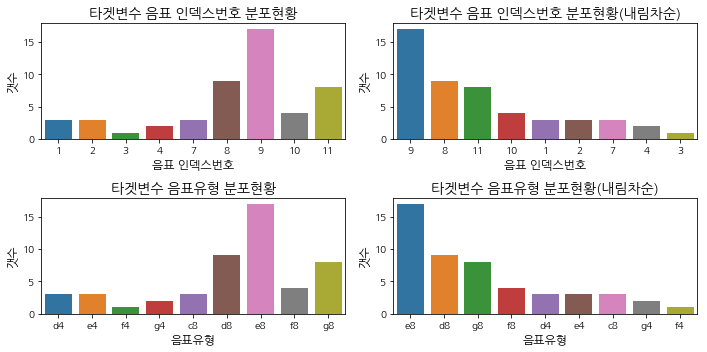

In [35]:
# 훈련 데이터셋 중 타겟변수 음표 분포그래프
fig = plt.figure(figsize = (10, 5))

plt.subplot(2, 2, 1)
ax = sns.barplot(x = 'idx', y = 'frequency', data = y_train_tb) 
ax.set_title('타겟변수 음표 인덱스번호 분포현황', size = 14) 
ax.set_xlabel('음표 인덱스번호', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 2)
ax = sns.barplot(x = 'idx', y = 'frequency', data = y_train_tb_sorted, 
                order = y_train_tb_sorted.idx.values) 
ax.set_title('타겟변수 음표 인덱스번호 분포현황(내림차순)', size = 14) 
ax.set_xlabel('음표 인덱스번호', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 3)
ax = sns.barplot(x = 'code', y = 'frequency', data = y_train_tb) 
ax.set_title('타겟변수 음표유형 분포현황', size = 14) 
ax.set_xlabel('음표유형', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.subplot(2, 2, 4)
ax = sns.barplot(x = 'code', y = 'frequency', data = y_train_tb_sorted, 
                order = y_train_tb_sorted.code.values) 
ax.set_title('타겟변수 음표유형 분포현황(내림차순)', size = 14) 
ax.set_xlabel('음표유형', size = 12) 
ax.set_ylabel('갯수', size = 12)

plt.tight_layout()

# <font color = 'blue'>데이터 전처리</font>

### 피처셋 스케일링: 음표 인덱스번호 수치를 0~1 사이로 변환
* sklearn라이브러리 preprocessing모듈의 minmax_scale() 함수를 이용해 최대/최소값이 각각 1, 0이 되도록 스케일링

In [36]:
from sklearn.preprocessing import minmax_scale

In [37]:
# 훈련용 데이터셋 중 피처셋 스케일링
X_train_scaled = minmax_scale(X_train)

print(f'[훈련용   피처셋] 최소:{np.min(X_train):3.1f}, 최대:{np.max(X_train):4.1f}', end = ", ")
print(f'평균:{X_train.mean():5.3f}, 표준편차:{X_train.std():5.3f}')
      
print(f'[스케일링 피처셋] 최소:{np.min(X_train_scaled):3.1f}, 최대:{np.max(X_train_scaled):4.1f}', end=", ")
print(f'평균:{X_train_scaled.mean():5.3f}, 표준편차:{X_train_scaled.std():5.3f}')

[훈련용   피처셋] 최소:1.0, 최대:11.0, 평균:7.935, 표준편차:2.878
[스케일링 피처셋] 최소:0.0, 최대: 1.0, 평균:0.693, 표준편차:0.288


In [38]:
# 스케일링을 통해 정규화한 피처셋 객체구조
print('스케일링한 피처셋 객체구조:', X_train_scaled.shape)
print('스케일링한 피처셋 레코드 갯수:', X_train_scaled.shape[0])
print('스케일링한 피처셋 변수컬럼 갯수:', X_train_scaled.shape[1])

스케일링한 피처셋 객체구조: (50, 4)
스케일링한 피처셋 레코드 갯수: 50
스케일링한 피처셋 변수컬럼 갯수: 4


### 타겟변수 원핫인코딩: 음표 인덱스번호를 이진벡터행렬로 구성
* 타겟변수가 다항 클래스인 경우 원핫인코딩으로 변경해 0과 1로 구성된 상태로 만들어야 딥러닝 연산이 가능해짐

In [39]:
# 원핫인코딩 모듈로딩
from keras.utils import np_utils

Using TensorFlow backend.


In [40]:
# 훈련셋 중 타겟변수 원핫인코딩
y_train_ohe = np_utils.to_categorical(y_train)

print(f'[훈련셋 타겟변수] 원본데이터 구조: {y_train.shape} => 원핫인코딩구조: {y_train_ohe.shape}')

y_train_ohe

[훈련셋 타겟변수] 원본데이터 구조: (50,) => 원핫인코딩구조: (50, 12)


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [41]:
# 원핫인코딩된 타겟변수 객체구조
print('원핫인코딩된 타겟변수 객체구조:', y_train_ohe.shape)
print('원핫인코딩된 타겟변수 레코드 갯수:', y_train_ohe.shape[0])
print('원핫인코딩된 타겟변수 변수컬럼 갯수:', y_train_ohe.shape[1])

원핫인코딩된 타겟변수 객체구조: (50, 12)
원핫인코딩된 타겟변수 레코드 갯수: 50
원핫인코딩된 타겟변수 변수컬럼 갯수: 12


# <font color = 'blue'>딥러닝 모델링</font>

### 딥러닝 라이브러리 로딩

In [42]:
# 딥러닝 관련 라이브러리
import tensorflow as tf
# - 딥러닝 학습알고리즘

from keras.models import Sequential
# - 딥러닝 학습계층을 순차적으로 쌓아올릴 수 있도록 해줌

from keras.layers import Dense, Dropout, Embedding, LSTM
# - 딥러닝 학습계층별 노드/유닛을 밀집시켜 학습방법을 설정할 수 있도록 해줌

### 랜덤 시드넘버 설정

In [43]:
# 무작위 시드넘버 설정으로 샘플 재현성 확보
myseed = 0

import numpy as np
np.random.seed(myseed)
tf.set_random_seed(myseed)

### 딥러닝 모델계층 설정

In [44]:
# 딥러닝 학습계층 시퀀스객체 로딩
md = Sequential()
# - 딥러닝 학습계층을 순차적으로 쌓아올릴 수 있는 Sequential()메서드를 md라는 객체로 로딩함

# 딥러닝 학습계층 설계
# - Dense() 객체로 학습계층별로 여러 개 노드가 밀집된 신경망을 구현함
# - 입력층(784개노드)-은닉층(512개노드)-출력층(10개노드)

# 입력층: 일반 덴스밀집층(완전연결층)
md.add(Dense(128, input_dim = X_train_scaled.shape[1], activation = 'relu'))
# -  스케일링한 피처셋 변수컬럼 갯수를 지정하기 위해서
#    input_dim = X_train_scaled.shape[1]을 사용함

# 은닉층: 일반 덴스밀집층(완전연결층)
md.add(Dense(64, activation = 'relu'))

# 출력층
md.add(Dense(y_train_ohe.shape[1], activation = 'softmax'))
# - 출력값을 원핫인코딩된 타겟변수 변수컬럼 갯수로 지정하기 위해서
#   y_train_ohe.shape[1]라는 코드를 사용함
# - activation = 'softmax'로 활성화함수 지정해 
#   최종적인 출력값을 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0과 같은 원핫인코딩 방식으로 도출

# 딥러닝 계층구조 요약
md.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 9,676
Trainable params: 9,676
Non-trainable params: 0
_________________________________________________________________


### 딥러닝 학습방법 설정

In [45]:
# 준비된 학습계층의 학습방법 설정
md.compile(loss = 'categorical_crossentropy', 
           optimizer = 'adam', metrics = ['accuracy'])

# - loss: 학습시 오차를 어떻방법으로 계산할지 설정
# - optimizser: 발생하는 오차를 어떤방법으로 줄여나갈지 설정
#   binary_crossentropy: 이항분류(binary-class classification)에 적합함
#   categorical_crossentropy: 다항분류(multi-class classification)에 적합함
# - metrics: 모형의 성능을 평가하는 기준으로 어떤 것을 사용할지 설정

### 학습모델 파일저장 옵션 설정

In [46]:
# 딥러닝 학습모델 저장폴더명 설정
import os

md_dir = './model/'
if not os.path.exists(md_dir):
    os.mkdir(md_dir)
    
# 딥러닝 학습모델별 저장파일명 변경설정
md_path = './model/vloss{val_loss:.3f}_vacc{val_acc:.3f}_ep{epoch:d}.hdf5'
# - loss: 전체데이터 중 훈련셋(training) 학습오차
# - acc: 전체데이터 중 훈련셋(training) 정확도
# - val_loss: 전체데이터 중 검증셋(validation) 오차
# - val_acc: 전체데이터 중 검증셋(validation) 정확도

# ep{epoch:d} 단위배치(batch) 작업인 엑폭번호를 정수형으로 파일명 시작부분에 기록
# vloss{val_loss:.3f} 각 학습모델의 검증데이터 오차정도를 소수3자리까지 파일에 기록
# vacc{val_acc:.3f} 각 학습모델의 검증데이터 정확정도를 소수3째자리까지 파일에 기록

### 학습모델 체크포인트 옵션 설정

In [47]:
# 학습모델 체크포인트 모듈 로딩
from keras.callbacks import ModelCheckpoint

In [48]:
# 체크포인트(checkpoint) 변경설정
cp = ModelCheckpoint(filepath = md_path, 
                     monitor = 'val_loss', 
                     verbose = 1, 
                     save_best_only = True)
# - filepath: 각 학습모델별 성능평가 파일저장 경로
# - monitor 옵션: 각 학습모델별 성능평가 기준
#   * 전체데이터 중 훈련셋(training) 학습오차: loss
#   * 전체데이터 중 훈련셋(training) 정확도: acc
#   * 전체데이터 중 검증셋(validation) 오차: val_loss
#   * 전체데이터 중 검증셋(validation) 정확도: val_acc
#   * 전체데이터 중 시험셋(테스트; test)은 별도로 분할해 놓아야 함
# - verbose: 모델별 학습진행사항 출력
# - save_best_only: 각 학습모델별 성능평가 파일저장시
#                   이전 모델보다 성능이 좋아졌을 때만 저장하도록 함

### 학습모델 과적합 방지 옵션 설정

In [49]:
# 과적합 방지용 종료 메서드 로딩
from keras.callbacks import EarlyStopping

In [50]:
# 조기종료 옵션설정
es = EarlyStopping(monitor = 'val_loss', patience = 300)
# - monitor: 검증셋 대상 모니터할 값 설정
# - patience: 검증셋 오차가 좋아지지 않아도 몇 번까지 기다릴지 설정

### 딥러닝 모델에 데이터 피팅

In [51]:
# 딥러닝 모델 최적화 훈련진행
# - 준비된 훈련계층과 훈련방법에 따라 미니배치(mini-batch) 방식으로 최적화 훈련진행
# - 훈련데이터셋을 한번에 투입해 또는 한개 샘플씩 학습을 하지 않고, 
#   일부(batch_size) 단위샘플로 나누어서 부분적으로 학습을 진행함
# - 미니배치를 하나씩 학습모델에 투입해 손실함수값을 줄이기 위한 파라미터(가중치, 편향)를 조율해 나감
# - 각 미니배치별 손실함수값을 구하고, 이들의 평균적인 오차와 정확도를 해당 모델의 성능으로 판단함
# - 또한 미니배치 단위샘플을 모두 사용하는 일련의 학습과정(에포크: epoch)을 
#   한번에 끝내는 것이 아니라 여러차례 반복실시해 모델의 성능을 개선해 나감  

history = md.fit(X_train_scaled, y_train_ohe, 
                 epochs = 2000, batch_size = 5, 
                 validation_split = 0.1, 
                 verbose = 1, 
                 callbacks = [cp, es])
# - 훈련셋을 5개 샘플씩 나누어 미니배치를 여러개 만들고 
#   이를 모두 활용하는 딥러닝 학습을 총 2000번 반복실시함

# - batch_size: 훈련데이터셋중에서 몇개 샘플을 미니배치(mini-batch)로 만들것인지 설정
#   적게설정: 빠른 훈련속도이점. 단위샘플셋에 따라 학습편차가 많이 발생. 병렬연산 못하고 하드웨어 자원낭비
#   많이설정: 훈련속도가 느려짐. 지역최소값(local minimum)에 빠질 수 있음. 하드웨어 자원에 부하가 많이 발생함)
# - epochs: 미니배치를 모두 처리하는 일련의 학습을 몇 번 정도 실시할지 설정
#   적게설정: 파라미터조율이 충분하지 않아서 과소적합 가능성
#   많이설정: 파라미터조율이 지나쳐 과대적합 가능성

# - validation_split = 0.2: 전체데이터중 훈련셋(training) 80%, 검증셋(validation) 20%로 분할하는 비율설정
# - callbacks 
#   [cp] 학습모델별 성능평가파일 생성방법 설정
#   [es] 딥러닝 과적합방지용 조기종료 옵션 설정

# 신경망 학습을 위한 데이터셋 3가지 유형
# - 훈련 데이터(training data): 매개변수(가중치와 편향) 학습
# - 검증 데이터(validation data): 하이퍼파라미터 성능 평가
# - 시험 데이터(test data): 신경망의 범용 성능 평가

# - validation_split = 0.1 대신에 별도 피처&타겟셋을 입력할 수 있음
# - validation_data = (X_testing_scaled, y_test_ohe)로 설정하면
#   시험셋을 검증용으로 투입한 것으로 볼 수 있음

Train on 45 samples, validate on 5 samples
Epoch 1/2000
45/45 [==============================] - 0s 7ms/step - loss: 2.4193 - acc: 0.2000 - val_loss: 2.3789 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 2.37889, saving model to ./model/vloss2.379_vacc0.200_ep1.hdf5
Epoch 2/2000
45/45 [==============================] - 0s 288us/step - loss: 2.2860 - acc: 0.2444 - val_loss: 2.2464 - val_acc: 0.4000

Epoch 00002: val_loss improved from 2.37889 to 2.24638, saving model to ./model/vloss2.246_vacc0.400_ep2.hdf5
Epoch 3/2000
45/45 [==============================] - 0s 377us/step - loss: 2.1930 - acc: 0.3333 - val_loss: 2.1506 - val_acc: 0.4000

Epoch 00003: val_loss improved from 2.24638 to 2.15057, saving model to ./model/vloss2.151_vacc0.400_ep3.hdf5
Epoch 4/2000
45/45 [==============================] - 0s 288us/step - loss: 2.0923 - acc: 0.3333 - val_loss: 2.0598 - val_acc: 0.4000

Epoch 00004: val_loss improved from 2.15057 to 2.05975, saving model to ./model/vloss2.060_va

45/45 [==============================] - 0s 266us/step - loss: 1.3771 - acc: 0.4889 - val_loss: 1.5779 - val_acc: 0.6000

Epoch 00077: val_loss did not improve from 1.57123
Epoch 78/2000
45/45 [==============================] - 0s 266us/step - loss: 1.3712 - acc: 0.5111 - val_loss: 1.5882 - val_acc: 0.6000

Epoch 00078: val_loss did not improve from 1.57123
Epoch 79/2000
45/45 [==============================] - 0s 288us/step - loss: 1.3750 - acc: 0.5556 - val_loss: 1.5677 - val_acc: 0.6000

Epoch 00079: val_loss improved from 1.57123 to 1.56769, saving model to ./model/vloss1.568_vacc0.600_ep79.hdf5
Epoch 80/2000
45/45 [==============================] - 0s 399us/step - loss: 1.3678 - acc: 0.5778 - val_loss: 1.5900 - val_acc: 0.6000

Epoch 00080: val_loss did not improve from 1.56769
Epoch 81/2000
45/45 [==============================] - 0s 310us/step - loss: 1.3654 - acc: 0.5778 - val_loss: 1.5680 - val_acc: 0.6000

Epoch 00081: val_loss did not improve from 1.56769
Epoch 82/2000
45/45

45/45 [==============================] - 0s 266us/step - loss: 1.1526 - acc: 0.5778 - val_loss: 1.2579 - val_acc: 0.4000

Epoch 00154: val_loss did not improve from 1.24693
Epoch 155/2000
45/45 [==============================] - 0s 288us/step - loss: 1.1627 - acc: 0.5111 - val_loss: 1.2695 - val_acc: 0.4000

Epoch 00155: val_loss did not improve from 1.24693
Epoch 156/2000
45/45 [==============================] - 0s 288us/step - loss: 1.1589 - acc: 0.5333 - val_loss: 1.2462 - val_acc: 0.4000

Epoch 00156: val_loss improved from 1.24693 to 1.24622, saving model to ./model/vloss1.246_vacc0.400_ep156.hdf5
Epoch 157/2000
45/45 [==============================] - 0s 399us/step - loss: 1.1419 - acc: 0.5333 - val_loss: 1.2423 - val_acc: 0.4000

Epoch 00157: val_loss improved from 1.24622 to 1.24229, saving model to ./model/vloss1.242_vacc0.400_ep157.hdf5
Epoch 158/2000
45/45 [==============================] - 0s 443us/step - loss: 1.1371 - acc: 0.5556 - val_loss: 1.2478 - val_acc: 0.4000

Epoc

45/45 [==============================] - 0s 332us/step - loss: 1.0469 - acc: 0.6000 - val_loss: 1.0821 - val_acc: 0.4000

Epoch 00194: val_loss did not improve from 1.05402
Epoch 195/2000
45/45 [==============================] - 0s 266us/step - loss: 1.0607 - acc: 0.5556 - val_loss: 1.0300 - val_acc: 0.6000

Epoch 00195: val_loss improved from 1.05402 to 1.03002, saving model to ./model/vloss1.030_vacc0.600_ep195.hdf5
Epoch 196/2000
45/45 [==============================] - 0s 288us/step - loss: 1.0351 - acc: 0.5778 - val_loss: 1.0703 - val_acc: 0.4000

Epoch 00196: val_loss did not improve from 1.03002
Epoch 197/2000
45/45 [==============================] - 0s 288us/step - loss: 1.0375 - acc: 0.6000 - val_loss: 1.0708 - val_acc: 0.4000

Epoch 00197: val_loss did not improve from 1.03002
Epoch 198/2000
45/45 [==============================] - 0s 288us/step - loss: 1.0369 - acc: 0.6000 - val_loss: 1.0670 - val_acc: 0.4000

Epoch 00198: val_loss did not improve from 1.03002
Epoch 199/2000

45/45 [==============================] - 0s 288us/step - loss: 0.8657 - acc: 0.6444 - val_loss: 0.7708 - val_acc: 0.6000

Epoch 00274: val_loss did not improve from 0.73300
Epoch 275/2000
45/45 [==============================] - 0s 332us/step - loss: 0.8528 - acc: 0.6444 - val_loss: 0.7363 - val_acc: 0.8000

Epoch 00275: val_loss did not improve from 0.73300
Epoch 276/2000
45/45 [==============================] - 0s 288us/step - loss: 0.8444 - acc: 0.6444 - val_loss: 0.7490 - val_acc: 0.6000

Epoch 00276: val_loss did not improve from 0.73300
Epoch 277/2000
45/45 [==============================] - 0s 288us/step - loss: 0.8375 - acc: 0.6667 - val_loss: 0.7492 - val_acc: 0.6000

Epoch 00277: val_loss did not improve from 0.73300
Epoch 278/2000
45/45 [==============================] - 0s 266us/step - loss: 0.8390 - acc: 0.6667 - val_loss: 0.7465 - val_acc: 0.6000

Epoch 00278: val_loss did not improve from 0.73300
Epoch 279/2000
45/45 [==============================] - 0s 266us/step - los

Epoch 356/2000
45/45 [==============================] - 0s 288us/step - loss: 0.7068 - acc: 0.7111 - val_loss: 0.5283 - val_acc: 0.8000

Epoch 00356: val_loss did not improve from 0.50636
Epoch 357/2000
45/45 [==============================] - 0s 332us/step - loss: 0.7097 - acc: 0.6889 - val_loss: 0.5324 - val_acc: 0.8000

Epoch 00357: val_loss did not improve from 0.50636
Epoch 358/2000
45/45 [==============================] - 0s 288us/step - loss: 0.6959 - acc: 0.7111 - val_loss: 0.5569 - val_acc: 0.8000

Epoch 00358: val_loss did not improve from 0.50636
Epoch 359/2000
45/45 [==============================] - 0s 266us/step - loss: 0.7127 - acc: 0.7111 - val_loss: 0.5293 - val_acc: 0.8000

Epoch 00359: val_loss did not improve from 0.50636
Epoch 360/2000
45/45 [==============================] - 0s 310us/step - loss: 0.7081 - acc: 0.7333 - val_loss: 0.5511 - val_acc: 0.8000

Epoch 00360: val_loss did not improve from 0.50636
Epoch 361/2000
45/45 [==============================] - 0s 3

Epoch 398/2000
45/45 [==============================] - 0s 310us/step - loss: 0.6579 - acc: 0.7333 - val_loss: 0.4982 - val_acc: 0.8000

Epoch 00398: val_loss did not improve from 0.44011
Epoch 399/2000
45/45 [==============================] - 0s 266us/step - loss: 0.6442 - acc: 0.7556 - val_loss: 0.4590 - val_acc: 1.0000

Epoch 00399: val_loss did not improve from 0.44011
Epoch 400/2000
45/45 [==============================] - 0s 310us/step - loss: 0.6456 - acc: 0.7556 - val_loss: 0.4177 - val_acc: 1.0000

Epoch 00400: val_loss improved from 0.44011 to 0.41765, saving model to ./model/vloss0.418_vacc1.000_ep400.hdf5
Epoch 401/2000
45/45 [==============================] - 0s 332us/step - loss: 0.6496 - acc: 0.7333 - val_loss: 0.4312 - val_acc: 1.0000

Epoch 00401: val_loss did not improve from 0.41765
Epoch 402/2000
45/45 [==============================] - 0s 288us/step - loss: 0.6498 - acc: 0.7778 - val_loss: 0.4464 - val_acc: 1.0000

Epoch 00402: val_loss did not improve from 0.41765


Epoch 00439: val_loss did not improve from 0.35107
Epoch 440/2000
45/45 [==============================] - 0s 332us/step - loss: 0.6153 - acc: 0.7778 - val_loss: 0.4545 - val_acc: 0.8000

Epoch 00440: val_loss did not improve from 0.35107
Epoch 441/2000
45/45 [==============================] - 0s 399us/step - loss: 0.5874 - acc: 0.7556 - val_loss: 0.3802 - val_acc: 1.0000

Epoch 00441: val_loss did not improve from 0.35107
Epoch 442/2000
45/45 [==============================] - 0s 643us/step - loss: 0.6047 - acc: 0.7778 - val_loss: 0.4016 - val_acc: 1.0000

Epoch 00442: val_loss did not improve from 0.35107
Epoch 443/2000
45/45 [==============================] - 0s 332us/step - loss: 0.6014 - acc: 0.7778 - val_loss: 0.4186 - val_acc: 1.0000

Epoch 00443: val_loss did not improve from 0.35107
Epoch 444/2000
45/45 [==============================] - 0s 288us/step - loss: 0.5929 - acc: 0.7778 - val_loss: 0.3646 - val_acc: 1.0000

Epoch 00444: val_loss did not improve from 0.35107
Epoch 44

45/45 [==============================] - 0s 288us/step - loss: 0.5526 - acc: 0.7778 - val_loss: 0.3263 - val_acc: 1.0000

Epoch 00482: val_loss did not improve from 0.28849
Epoch 483/2000
45/45 [==============================] - 0s 288us/step - loss: 0.5529 - acc: 0.8000 - val_loss: 0.3258 - val_acc: 1.0000

Epoch 00483: val_loss did not improve from 0.28849
Epoch 484/2000
45/45 [==============================] - 0s 288us/step - loss: 0.5469 - acc: 0.8000 - val_loss: 0.3484 - val_acc: 1.0000

Epoch 00484: val_loss did not improve from 0.28849
Epoch 485/2000
45/45 [==============================] - 0s 266us/step - loss: 0.5626 - acc: 0.7556 - val_loss: 0.3196 - val_acc: 1.0000

Epoch 00485: val_loss did not improve from 0.28849
Epoch 486/2000
45/45 [==============================] - 0s 288us/step - loss: 0.5655 - acc: 0.8222 - val_loss: 0.3820 - val_acc: 0.8000

Epoch 00486: val_loss did not improve from 0.28849
Epoch 487/2000
45/45 [==============================] - 0s 288us/step - los

45/45 [==============================] - 0s 266us/step - loss: 0.5058 - acc: 0.8222 - val_loss: 0.2563 - val_acc: 1.0000

Epoch 00566: val_loss did not improve from 0.20608
Epoch 567/2000
45/45 [==============================] - 0s 310us/step - loss: 0.4733 - acc: 0.8444 - val_loss: 0.2158 - val_acc: 1.0000

Epoch 00567: val_loss did not improve from 0.20608
Epoch 568/2000
45/45 [==============================] - 0s 377us/step - loss: 0.4880 - acc: 0.7778 - val_loss: 0.2222 - val_acc: 1.0000

Epoch 00568: val_loss did not improve from 0.20608
Epoch 569/2000
45/45 [==============================] - 0s 310us/step - loss: 0.4793 - acc: 0.8222 - val_loss: 0.2845 - val_acc: 1.0000

Epoch 00569: val_loss did not improve from 0.20608
Epoch 570/2000
45/45 [==============================] - 0s 310us/step - loss: 0.4779 - acc: 0.8222 - val_loss: 0.2526 - val_acc: 1.0000

Epoch 00570: val_loss did not improve from 0.20608
Epoch 571/2000
45/45 [==============================] - 0s 576us/step - los

45/45 [==============================] - 0s 310us/step - loss: 0.4118 - acc: 0.8667 - val_loss: 0.1791 - val_acc: 1.0000

Epoch 00650: val_loss did not improve from 0.15075
Epoch 651/2000
45/45 [==============================] - 0s 288us/step - loss: 0.4306 - acc: 0.8222 - val_loss: 0.1896 - val_acc: 1.0000

Epoch 00651: val_loss did not improve from 0.15075
Epoch 652/2000
45/45 [==============================] - 0s 266us/step - loss: 0.4431 - acc: 0.8444 - val_loss: 0.1613 - val_acc: 1.0000

Epoch 00652: val_loss did not improve from 0.15075
Epoch 653/2000
45/45 [==============================] - 0s 266us/step - loss: 0.4055 - acc: 0.8444 - val_loss: 0.2116 - val_acc: 1.0000

Epoch 00653: val_loss did not improve from 0.15075
Epoch 654/2000
45/45 [==============================] - 0s 288us/step - loss: 0.4485 - acc: 0.8222 - val_loss: 0.1713 - val_acc: 1.0000

Epoch 00654: val_loss did not improve from 0.15075
Epoch 655/2000
45/45 [==============================] - 0s 310us/step - los


Epoch 00692: val_loss did not improve from 0.12212
Epoch 693/2000
45/45 [==============================] - 0s 266us/step - loss: 0.3881 - acc: 0.8667 - val_loss: 0.1578 - val_acc: 1.0000

Epoch 00693: val_loss did not improve from 0.12212
Epoch 694/2000
45/45 [==============================] - 0s 266us/step - loss: 0.3876 - acc: 0.8444 - val_loss: 0.1459 - val_acc: 1.0000

Epoch 00694: val_loss did not improve from 0.12212
Epoch 695/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3919 - acc: 0.8444 - val_loss: 0.1476 - val_acc: 1.0000

Epoch 00695: val_loss did not improve from 0.12212
Epoch 696/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3867 - acc: 0.8444 - val_loss: 0.1411 - val_acc: 1.0000

Epoch 00696: val_loss did not improve from 0.12212
Epoch 697/2000
45/45 [==============================] - 0s 266us/step - loss: 0.3783 - acc: 0.8667 - val_loss: 0.1296 - val_acc: 1.0000

Epoch 00697: val_loss did not improve from 0.12212
Epoch 69


Epoch 00734: val_loss did not improve from 0.10206
Epoch 735/2000
45/45 [==============================] - 0s 332us/step - loss: 0.3667 - acc: 0.8667 - val_loss: 0.1150 - val_acc: 1.0000

Epoch 00735: val_loss did not improve from 0.10206
Epoch 736/2000
45/45 [==============================] - 0s 466us/step - loss: 0.3835 - acc: 0.8444 - val_loss: 0.1523 - val_acc: 1.0000

Epoch 00736: val_loss did not improve from 0.10206
Epoch 737/2000
45/45 [==============================] - 0s 377us/step - loss: 0.3672 - acc: 0.8222 - val_loss: 0.1178 - val_acc: 1.0000

Epoch 00737: val_loss did not improve from 0.10206
Epoch 738/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3738 - acc: 0.8444 - val_loss: 0.1379 - val_acc: 1.0000

Epoch 00738: val_loss did not improve from 0.10206
Epoch 739/2000
45/45 [==============================] - 0s 332us/step - loss: 0.3700 - acc: 0.8444 - val_loss: 0.1415 - val_acc: 1.0000

Epoch 00739: val_loss did not improve from 0.10206
Epoch 74


Epoch 00777: val_loss improved from 0.09172 to 0.09146, saving model to ./model/vloss0.091_vacc1.000_ep777.hdf5
Epoch 778/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3616 - acc: 0.8222 - val_loss: 0.1351 - val_acc: 1.0000

Epoch 00778: val_loss did not improve from 0.09146
Epoch 779/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3597 - acc: 0.8444 - val_loss: 0.0920 - val_acc: 1.0000

Epoch 00779: val_loss did not improve from 0.09146
Epoch 780/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3542 - acc: 0.8667 - val_loss: 0.1207 - val_acc: 1.0000

Epoch 00780: val_loss did not improve from 0.09146
Epoch 781/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3730 - acc: 0.8222 - val_loss: 0.1587 - val_acc: 1.0000

Epoch 00781: val_loss did not improve from 0.09146
Epoch 782/2000
45/45 [==============================] - 0s 532us/step - loss: 0.3638 - acc: 0.8667 - val_loss: 0.0725 - val_acc: 1.0000


Epoch 00820: val_loss did not improve from 0.07251
Epoch 821/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3572 - acc: 0.8222 - val_loss: 0.0980 - val_acc: 1.0000

Epoch 00821: val_loss did not improve from 0.07251
Epoch 822/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3295 - acc: 0.8222 - val_loss: 0.1022 - val_acc: 1.0000

Epoch 00822: val_loss did not improve from 0.07251
Epoch 823/2000
45/45 [==============================] - 0s 266us/step - loss: 0.3358 - acc: 0.8222 - val_loss: 0.0894 - val_acc: 1.0000

Epoch 00823: val_loss did not improve from 0.07251
Epoch 824/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3485 - acc: 0.8222 - val_loss: 0.0951 - val_acc: 1.0000

Epoch 00824: val_loss did not improve from 0.07251
Epoch 825/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3272 - acc: 0.8222 - val_loss: 0.1040 - val_acc: 1.0000

Epoch 00825: val_loss did not improve from 0.07251
Epoch 82


Epoch 00863: val_loss did not improve from 0.05849
Epoch 864/2000
45/45 [==============================] - 0s 266us/step - loss: 0.3083 - acc: 0.8667 - val_loss: 0.0659 - val_acc: 1.0000

Epoch 00864: val_loss did not improve from 0.05849
Epoch 865/2000
45/45 [==============================] - 0s 332us/step - loss: 0.3353 - acc: 0.8444 - val_loss: 0.0750 - val_acc: 1.0000

Epoch 00865: val_loss did not improve from 0.05849
Epoch 866/2000
45/45 [==============================] - 0s 355us/step - loss: 0.3057 - acc: 0.8667 - val_loss: 0.0988 - val_acc: 1.0000

Epoch 00866: val_loss did not improve from 0.05849
Epoch 867/2000
45/45 [==============================] - 0s 310us/step - loss: 0.3236 - acc: 0.8444 - val_loss: 0.0636 - val_acc: 1.0000

Epoch 00867: val_loss did not improve from 0.05849
Epoch 868/2000
45/45 [==============================] - 0s 443us/step - loss: 0.3186 - acc: 0.8667 - val_loss: 0.0677 - val_acc: 1.0000

Epoch 00868: val_loss did not improve from 0.05849
Epoch 86

45/45 [==============================] - 0s 310us/step - loss: 0.2861 - acc: 0.8889 - val_loss: 0.0589 - val_acc: 1.0000

Epoch 00949: val_loss did not improve from 0.04406
Epoch 950/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2957 - acc: 0.8667 - val_loss: 0.0423 - val_acc: 1.0000

Epoch 00950: val_loss improved from 0.04406 to 0.04229, saving model to ./model/vloss0.042_vacc1.000_ep950.hdf5
Epoch 951/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2817 - acc: 0.8889 - val_loss: 0.0680 - val_acc: 1.0000

Epoch 00951: val_loss did not improve from 0.04229
Epoch 952/2000
45/45 [==============================] - 0s 288us/step - loss: 0.3013 - acc: 0.8444 - val_loss: 0.0592 - val_acc: 1.0000

Epoch 00952: val_loss did not improve from 0.04229
Epoch 953/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2890 - acc: 0.8667 - val_loss: 0.0564 - val_acc: 1.0000

Epoch 00953: val_loss did not improve from 0.04229
Epoch 954/2000

45/45 [==============================] - 0s 310us/step - loss: 0.2616 - acc: 0.8889 - val_loss: 0.0314 - val_acc: 1.0000

Epoch 01033: val_loss improved from 0.03243 to 0.03143, saving model to ./model/vloss0.031_vacc1.000_ep1033.hdf5
Epoch 1034/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2749 - acc: 0.8889 - val_loss: 0.0434 - val_acc: 1.0000

Epoch 01034: val_loss did not improve from 0.03143
Epoch 1035/2000
45/45 [==============================] - 0s 332us/step - loss: 0.2644 - acc: 0.8889 - val_loss: 0.0579 - val_acc: 1.0000

Epoch 01035: val_loss did not improve from 0.03143
Epoch 1036/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2640 - acc: 0.8889 - val_loss: 0.0472 - val_acc: 1.0000

Epoch 01036: val_loss did not improve from 0.03143
Epoch 1037/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2698 - acc: 0.8667 - val_loss: 0.0321 - val_acc: 1.0000

Epoch 01037: val_loss did not improve from 0.03143
Epoch 103


Epoch 01117: val_loss did not improve from 0.02338
Epoch 1118/2000
45/45 [==============================] - 0s 332us/step - loss: 0.2422 - acc: 0.8889 - val_loss: 0.0237 - val_acc: 1.0000

Epoch 01118: val_loss did not improve from 0.02338
Epoch 1119/2000
45/45 [==============================] - 0s 332us/step - loss: 0.2471 - acc: 0.8667 - val_loss: 0.0304 - val_acc: 1.0000

Epoch 01119: val_loss did not improve from 0.02338
Epoch 1120/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2494 - acc: 0.8889 - val_loss: 0.0398 - val_acc: 1.0000

Epoch 01120: val_loss did not improve from 0.02338
Epoch 1121/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2389 - acc: 0.8889 - val_loss: 0.0291 - val_acc: 1.0000

Epoch 01121: val_loss did not improve from 0.02338
Epoch 1122/2000
45/45 [==============================] - 0s 377us/step - loss: 0.2400 - acc: 0.8889 - val_loss: 0.0280 - val_acc: 1.0000

Epoch 01122: val_loss did not improve from 0.02338
Epo

45/45 [==============================] - 0s 288us/step - loss: 0.2370 - acc: 0.8889 - val_loss: 0.0238 - val_acc: 1.0000

Epoch 01161: val_loss did not improve from 0.01867
Epoch 1162/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2468 - acc: 0.8889 - val_loss: 0.0191 - val_acc: 1.0000

Epoch 01162: val_loss did not improve from 0.01867
Epoch 1163/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2514 - acc: 0.8889 - val_loss: 0.0325 - val_acc: 1.0000

Epoch 01163: val_loss did not improve from 0.01867
Epoch 1164/2000
45/45 [==============================] - 0s 266us/step - loss: 0.2418 - acc: 0.9111 - val_loss: 0.0264 - val_acc: 1.0000

Epoch 01164: val_loss did not improve from 0.01867
Epoch 1165/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2354 - acc: 0.8889 - val_loss: 0.0184 - val_acc: 1.0000

Epoch 01165: val_loss improved from 0.01867 to 0.01841, saving model to ./model/vloss0.018_vacc1.000_ep1165.hdf5
Epoch 116

45/45 [==============================] - 0s 288us/step - loss: 0.2277 - acc: 0.8889 - val_loss: 0.0243 - val_acc: 1.0000

Epoch 01245: val_loss did not improve from 0.01342
Epoch 1246/2000
45/45 [==============================] - 0s 621us/step - loss: 0.2428 - acc: 0.8444 - val_loss: 0.0166 - val_acc: 1.0000

Epoch 01246: val_loss did not improve from 0.01342
Epoch 1247/2000
45/45 [==============================] - 0s 332us/step - loss: 0.2630 - acc: 0.8444 - val_loss: 0.0384 - val_acc: 1.0000

Epoch 01247: val_loss did not improve from 0.01342
Epoch 1248/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2200 - acc: 0.9111 - val_loss: 0.0172 - val_acc: 1.0000

Epoch 01248: val_loss did not improve from 0.01342
Epoch 1249/2000
45/45 [==============================] - 0s 377us/step - loss: 0.2307 - acc: 0.8889 - val_loss: 0.0165 - val_acc: 1.0000

Epoch 01249: val_loss did not improve from 0.01342
Epoch 1250/2000
45/45 [==============================] - 0s 310us/step 

45/45 [==============================] - 0s 355us/step - loss: 0.2476 - acc: 0.8889 - val_loss: 0.0124 - val_acc: 1.0000

Epoch 01288: val_loss improved from 0.01265 to 0.01235, saving model to ./model/vloss0.012_vacc1.000_ep1288.hdf5
Epoch 1289/2000
45/45 [==============================] - 0s 332us/step - loss: 0.2191 - acc: 0.8889 - val_loss: 0.0175 - val_acc: 1.0000

Epoch 01289: val_loss did not improve from 0.01235
Epoch 1290/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2209 - acc: 0.8667 - val_loss: 0.0222 - val_acc: 1.0000

Epoch 01290: val_loss did not improve from 0.01235
Epoch 1291/2000
45/45 [==============================] - 0s 266us/step - loss: 0.2478 - acc: 0.8667 - val_loss: 0.0202 - val_acc: 1.0000

Epoch 01291: val_loss did not improve from 0.01235
Epoch 1292/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2165 - acc: 0.8889 - val_loss: 0.0132 - val_acc: 1.0000

Epoch 01292: val_loss did not improve from 0.01235
Epoch 129


Epoch 01372: val_loss did not improve from 0.00949
Epoch 1373/2000
45/45 [==============================] - 0s 421us/step - loss: 0.2275 - acc: 0.9111 - val_loss: 0.0078 - val_acc: 1.0000

Epoch 01373: val_loss improved from 0.00949 to 0.00779, saving model to ./model/vloss0.008_vacc1.000_ep1373.hdf5
Epoch 1374/2000
45/45 [==============================] - 0s 465us/step - loss: 0.2208 - acc: 0.8667 - val_loss: 0.0159 - val_acc: 1.0000

Epoch 01374: val_loss did not improve from 0.00779
Epoch 1375/2000
45/45 [==============================] - 0s 355us/step - loss: 0.2182 - acc: 0.8889 - val_loss: 0.0153 - val_acc: 1.0000

Epoch 01375: val_loss did not improve from 0.00779
Epoch 1376/2000
45/45 [==============================] - 0s 399us/step - loss: 0.2201 - acc: 0.8667 - val_loss: 0.0107 - val_acc: 1.0000

Epoch 01376: val_loss did not improve from 0.00779
Epoch 1377/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2155 - acc: 0.9111 - val_loss: 0.0101 - val_acc: 


Epoch 01457: val_loss did not improve from 0.00581
Epoch 1458/2000
45/45 [==============================] - ETA: 0s - loss: 0.2786 - acc: 0.800 - 0s 288us/step - loss: 0.2089 - acc: 0.9111 - val_loss: 0.0147 - val_acc: 1.0000

Epoch 01458: val_loss did not improve from 0.00581
Epoch 1459/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2123 - acc: 0.9111 - val_loss: 0.0078 - val_acc: 1.0000

Epoch 01459: val_loss did not improve from 0.00581
Epoch 1460/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2166 - acc: 0.8667 - val_loss: 0.0118 - val_acc: 1.0000

Epoch 01460: val_loss did not improve from 0.00581
Epoch 1461/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2295 - acc: 0.8889 - val_loss: 0.0099 - val_acc: 1.0000

Epoch 01461: val_loss did not improve from 0.00581
Epoch 1462/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2006 - acc: 0.9111 - val_loss: 0.0104 - val_acc: 1.0000

Epoch 01462: val

45/45 [==============================] - 0s 355us/step - loss: 0.2020 - acc: 0.8889 - val_loss: 0.0077 - val_acc: 1.0000

Epoch 01501: val_loss did not improve from 0.00581
Epoch 1502/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2029 - acc: 0.9111 - val_loss: 0.0082 - val_acc: 1.0000

Epoch 01502: val_loss did not improve from 0.00581
Epoch 1503/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2269 - acc: 0.8889 - val_loss: 0.0076 - val_acc: 1.0000

Epoch 01503: val_loss did not improve from 0.00581
Epoch 1504/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2254 - acc: 0.8889 - val_loss: 0.0208 - val_acc: 1.0000

Epoch 01504: val_loss did not improve from 0.00581
Epoch 1505/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2042 - acc: 0.8667 - val_loss: 0.0122 - val_acc: 1.0000

Epoch 01505: val_loss did not improve from 0.00581
Epoch 1506/2000
45/45 [==============================] - 0s 310us/step 

Epoch 1544/2000
45/45 [==============================] - ETA: 0s - loss: 0.0066 - acc: 1.000 - 0s 310us/step - loss: 0.2174 - acc: 0.8667 - val_loss: 0.0117 - val_acc: 1.0000

Epoch 01544: val_loss did not improve from 0.00525
Epoch 1545/2000
45/45 [==============================] - ETA: 0s - loss: 0.1099 - acc: 1.000 - 0s 309us/step - loss: 0.2115 - acc: 0.8667 - val_loss: 0.0076 - val_acc: 1.0000

Epoch 01545: val_loss did not improve from 0.00525
Epoch 1546/2000
45/45 [==============================] - 0s 266us/step - loss: 0.1968 - acc: 0.9111 - val_loss: 0.0065 - val_acc: 1.0000

Epoch 01546: val_loss did not improve from 0.00525
Epoch 1547/2000
45/45 [==============================] - 0s 310us/step - loss: 0.1972 - acc: 0.8889 - val_loss: 0.0068 - val_acc: 1.0000

Epoch 01547: val_loss did not improve from 0.00525
Epoch 1548/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2071 - acc: 0.8889 - val_loss: 0.0096 - val_acc: 1.0000

Epoch 01548: val_loss did not 


Epoch 01628: val_loss did not improve from 0.00337
Epoch 1629/2000
45/45 [==============================] - 0s 310us/step - loss: 0.1988 - acc: 0.8889 - val_loss: 0.0062 - val_acc: 1.0000

Epoch 01629: val_loss did not improve from 0.00337
Epoch 1630/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1987 - acc: 0.8889 - val_loss: 0.0048 - val_acc: 1.0000

Epoch 01630: val_loss did not improve from 0.00337
Epoch 1631/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2140 - acc: 0.8889 - val_loss: 0.0080 - val_acc: 1.0000

Epoch 01631: val_loss did not improve from 0.00337
Epoch 1632/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2053 - acc: 0.9111 - val_loss: 0.0055 - val_acc: 1.0000

Epoch 01632: val_loss did not improve from 0.00337
Epoch 1633/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2009 - acc: 0.8667 - val_loss: 0.0041 - val_acc: 1.0000

Epoch 01633: val_loss did not improve from 0.00337
Epo

45/45 [==============================] - 0s 288us/step - loss: 0.1892 - acc: 0.8889 - val_loss: 0.0052 - val_acc: 1.0000

Epoch 01672: val_loss did not improve from 0.00337
Epoch 1673/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1977 - acc: 0.8889 - val_loss: 0.0056 - val_acc: 1.0000

Epoch 01673: val_loss did not improve from 0.00337
Epoch 1674/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1988 - acc: 0.8889 - val_loss: 0.0039 - val_acc: 1.0000

Epoch 01674: val_loss did not improve from 0.00337
Epoch 1675/2000
45/45 [==============================] - 0s 377us/step - loss: 0.2049 - acc: 0.8667 - val_loss: 0.0042 - val_acc: 1.0000

Epoch 01675: val_loss did not improve from 0.00337
Epoch 1676/2000
45/45 [==============================] - 0s 355us/step - loss: 0.2237 - acc: 0.8889 - val_loss: 0.0082 - val_acc: 1.0000

Epoch 01676: val_loss did not improve from 0.00337
Epoch 1677/2000
45/45 [==============================] - 0s 310us/step 

45/45 [==============================] - 0s 310us/step - loss: 0.2015 - acc: 0.8889 - val_loss: 0.0028 - val_acc: 1.0000

Epoch 01715: val_loss did not improve from 0.00229
Epoch 1716/2000
45/45 [==============================] - 0s 332us/step - loss: 0.1889 - acc: 0.8667 - val_loss: 0.0071 - val_acc: 1.0000

Epoch 01716: val_loss did not improve from 0.00229
Epoch 1717/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2026 - acc: 0.8889 - val_loss: 0.0056 - val_acc: 1.0000

Epoch 01717: val_loss did not improve from 0.00229
Epoch 1718/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1919 - acc: 0.8889 - val_loss: 0.0046 - val_acc: 1.0000

Epoch 01718: val_loss did not improve from 0.00229
Epoch 1719/2000
45/45 [==============================] - 0s 266us/step - loss: 0.1927 - acc: 0.8889 - val_loss: 0.0062 - val_acc: 1.0000

Epoch 01719: val_loss did not improve from 0.00229
Epoch 1720/2000
45/45 [==============================] - 0s 310us/step 


Epoch 01800: val_loss did not improve from 0.00163
Epoch 1801/2000
45/45 [==============================] - 0s 332us/step - loss: 0.1799 - acc: 0.9111 - val_loss: 0.0029 - val_acc: 1.0000

Epoch 01801: val_loss did not improve from 0.00163
Epoch 1802/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1821 - acc: 0.8889 - val_loss: 0.0030 - val_acc: 1.0000

Epoch 01802: val_loss did not improve from 0.00163
Epoch 1803/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1933 - acc: 0.8889 - val_loss: 0.0049 - val_acc: 1.0000

Epoch 01803: val_loss did not improve from 0.00163
Epoch 1804/2000
45/45 [==============================] - 0s 310us/step - loss: 0.2029 - acc: 0.8889 - val_loss: 0.0020 - val_acc: 1.0000

Epoch 01804: val_loss did not improve from 0.00163
Epoch 1805/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1758 - acc: 0.9111 - val_loss: 0.0023 - val_acc: 1.0000

Epoch 01805: val_loss did not improve from 0.00163
Epo

45/45 [==============================] - 0s 310us/step - loss: 0.1961 - acc: 0.8667 - val_loss: 0.0050 - val_acc: 1.0000

Epoch 01844: val_loss did not improve from 0.00163
Epoch 1845/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1983 - acc: 0.8889 - val_loss: 0.0062 - val_acc: 1.0000

Epoch 01845: val_loss did not improve from 0.00163
Epoch 1846/2000
45/45 [==============================] - 0s 310us/step - loss: 0.1914 - acc: 0.8667 - val_loss: 0.0042 - val_acc: 1.0000

Epoch 01846: val_loss did not improve from 0.00163
Epoch 1847/2000
45/45 [==============================] - 0s 222us/step - loss: 0.1836 - acc: 0.9111 - val_loss: 0.0053 - val_acc: 1.0000

Epoch 01847: val_loss did not improve from 0.00163
Epoch 1848/2000
45/45 [==============================] - 0s 266us/step - loss: 0.1822 - acc: 0.9111 - val_loss: 0.0045 - val_acc: 1.0000

Epoch 01848: val_loss did not improve from 0.00163
Epoch 1849/2000
45/45 [==============================] - 0s 310us/step 

45/45 [==============================] - 0s 310us/step - loss: 0.1934 - acc: 0.8889 - val_loss: 0.0025 - val_acc: 1.0000

Epoch 01930: val_loss did not improve from 0.00163
Epoch 1931/2000
45/45 [==============================] - 0s 288us/step - loss: 0.2096 - acc: 0.8667 - val_loss: 0.0056 - val_acc: 1.0000

Epoch 01931: val_loss did not improve from 0.00163
Epoch 1932/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1851 - acc: 0.9111 - val_loss: 0.0041 - val_acc: 1.0000

Epoch 01932: val_loss did not improve from 0.00163
Epoch 1933/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1754 - acc: 0.9111 - val_loss: 0.0022 - val_acc: 1.0000

Epoch 01933: val_loss did not improve from 0.00163
Epoch 1934/2000
45/45 [==============================] - 0s 310us/step - loss: 0.1770 - acc: 0.8889 - val_loss: 0.0026 - val_acc: 1.0000

Epoch 01934: val_loss did not improve from 0.00163
Epoch 1935/2000
45/45 [==============================] - 0s 266us/step 

45/45 [==============================] - 0s 266us/step - loss: 0.2152 - acc: 0.8444 - val_loss: 0.0049 - val_acc: 1.0000

Epoch 01973: val_loss did not improve from 0.00163
Epoch 1974/2000
45/45 [==============================] - 0s 288us/step - loss: 0.1877 - acc: 0.9111 - val_loss: 0.0020 - val_acc: 1.0000

Epoch 01974: val_loss did not improve from 0.00163
Epoch 1975/2000
45/45 [==============================] - 0s 266us/step - loss: 0.1969 - acc: 0.8889 - val_loss: 0.0035 - val_acc: 1.0000

Epoch 01975: val_loss did not improve from 0.00163
Epoch 1976/2000
45/45 [==============================] - 0s 355us/step - loss: 0.1754 - acc: 0.8889 - val_loss: 0.0039 - val_acc: 1.0000

Epoch 01976: val_loss did not improve from 0.00163
Epoch 1977/2000
45/45 [==============================] - 0s 332us/step - loss: 0.1884 - acc: 0.8889 - val_loss: 0.0035 - val_acc: 1.0000

Epoch 01977: val_loss did not improve from 0.00163
Epoch 1978/2000
45/45 [==============================] - 0s 310us/step 

# <font color = 'blue'>딥러닝 모델 성능평가</font>

### 딥러닝 학습모델 성능평가 히스토리

In [52]:
# 딥러닝 학습실시에 따른 성능평가 히스토리 확보

# 훈련셋(training) 학습성능
y_loss = history.history['loss'] # 훈련셋 오차
y_acc = history.history['acc'] # 훈련셋 정확도

# 검증셋(validation) 학습성능
y_vloss = history.history['val_loss'] # 검증셋 오차
y_vacc = history.history['val_acc'] # 검증셋 정확도

In [53]:
# 딥러닝 학습실시에 따른 성능평가 히스토리 객체형식과 규모
print(type(y_loss), len(y_loss))
print(type(y_acc), len(y_acc))
print(type(y_vloss), len(y_vloss))
print(type(y_vacc), len(y_vacc))

<class 'list'> 2000
<class 'list'> 2000
<class 'list'> 2000
<class 'list'> 2000


In [54]:
print('훈련셋   오차추이:', [round(i, 3) for i in y_loss])
print('테스트셋 오차추이:', [round(i, 3) for i in y_vloss])

print()

print('훈련셋   정확도추이:', [round(i, 3) for i in y_acc])
print('테스트셋 정확도추이:', [round(i, 3) for i in y_vacc])

훈련셋   오차추이: [2.419, 2.286, 2.193, 2.092, 2.013, 1.953, 1.918, 1.892, 1.859, 1.84, 1.816, 1.805, 1.785, 1.769, 1.746, 1.737, 1.716, 1.713, 1.693, 1.684, 1.672, 1.66, 1.649, 1.644, 1.626, 1.619, 1.612, 1.601, 1.591, 1.591, 1.576, 1.571, 1.571, 1.559, 1.563, 1.546, 1.541, 1.539, 1.536, 1.523, 1.522, 1.517, 1.512, 1.501, 1.494, 1.503, 1.488, 1.489, 1.487, 1.479, 1.475, 1.472, 1.47, 1.465, 1.459, 1.453, 1.455, 1.438, 1.447, 1.44, 1.433, 1.431, 1.429, 1.417, 1.42, 1.419, 1.413, 1.409, 1.404, 1.404, 1.395, 1.402, 1.41, 1.392, 1.394, 1.384, 1.377, 1.371, 1.375, 1.368, 1.365, 1.36, 1.364, 1.352, 1.353, 1.351, 1.346, 1.34, 1.35, 1.34, 1.333, 1.33, 1.333, 1.341, 1.32, 1.327, 1.328, 1.323, 1.311, 1.311, 1.305, 1.298, 1.303, 1.295, 1.295, 1.295, 1.284, 1.288, 1.278, 1.272, 1.272, 1.272, 1.27, 1.27, 1.282, 1.256, 1.262, 1.255, 1.249, 1.258, 1.267, 1.248, 1.233, 1.234, 1.229, 1.235, 1.226, 1.234, 1.22, 1.213, 1.227, 1.203, 1.22, 1.221, 1.206, 1.208, 1.197, 1.2, 1.197, 1.199, 1.196, 1.223, 1.182, 1.18

훈련셋   정확도추이: [0.2, 0.244, 0.333, 0.333, 0.333, 0.333, 0.333, 0.333, 0.333, 0.356, 0.378, 0.4, 0.378, 0.4, 0.378, 0.4, 0.4, 0.4, 0.4, 0.422, 0.4, 0.4, 0.422, 0.4, 0.378, 0.4, 0.378, 0.378, 0.378, 0.378, 0.4, 0.4, 0.422, 0.444, 0.467, 0.489, 0.422, 0.4, 0.378, 0.4, 0.489, 0.489, 0.422, 0.422, 0.489, 0.489, 0.489, 0.489, 0.467, 0.489, 0.467, 0.511, 0.511, 0.511, 0.422, 0.467, 0.489, 0.489, 0.511, 0.511, 0.511, 0.511, 0.511, 0.511, 0.511, 0.489, 0.467, 0.444, 0.489, 0.489, 0.511, 0.511, 0.444, 0.467, 0.533, 0.556, 0.489, 0.511, 0.556, 0.578, 0.578, 0.556, 0.489, 0.489, 0.578, 0.578, 0.556, 0.533, 0.556, 0.556, 0.556, 0.556, 0.578, 0.533, 0.511, 0.578, 0.556, 0.533, 0.489, 0.556, 0.578, 0.578, 0.533, 0.533, 0.578, 0.578, 0.533, 0.511, 0.556, 0.556, 0.489, 0.556, 0.511, 0.556, 0.578, 0.556, 0.489, 0.533, 0.556, 0.556, 0.533, 0.556, 0.556, 0.556, 0.533, 0.533, 0.556, 0.511, 0.444, 0.511, 0.511, 0.578, 0.578, 0.533, 0.533, 0.556, 0.556, 0.511, 0.6, 0.578, 0.533, 0.489, 0.511, 0.533, 0.578, 0.5

### 딥러닝 학습모델 성능평가 그래프

In [55]:
# x축 설정
# - epochs = 200에 의해서 딥러닝 학습모델이 200개 만들어저 진행됨에 따라
#   학습오차, 학습정확도, 검증오차, 검증정확도가 모두 200개 값이 생성됨
# - 그런데, callbacks = [cp, es] 파라미터 설정으로 
#   개선된 베스트모델&과적합방지 학습모델에 대해서만 제한적으로  
#   학습오차, 학습정확도, 검증오차, 검증정확도가 기록됨  
#   [cp] 학습모델별 성능평가파일 생성시 
#        이전파일보다 성능이 개선된 베스트모델을 저장옵션
#   [es] 딥러닝 과적합방지용 조기종료 옵션 
x_len = np.arange(len(y_acc))
x_len

array([   0,    1,    2, ..., 1997, 1998, 1999])

#### 딥러닝학습 훈련셋과 검증셋 오차 추이

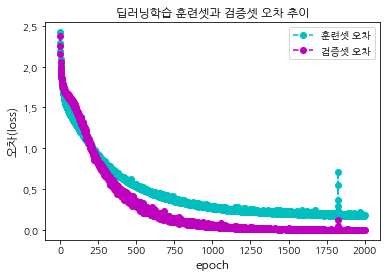

In [56]:
# 딥러닝학습 훈련셋과 검증셋 오차 추이
plt.plot(x_len, y_loss, 'co--', label = '훈련셋 오차')
plt.plot(x_len, y_vloss, 'mo--', label = '검증셋 오차')
plt.title('딥러닝학습 훈련셋과 검증셋 오차 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('오차(loss)', size = 12)
plt.legend()

# 마커설정 옵션 'co--', 'mo--'
# --> color = 'cyan', marker = 'o', linestyle = '--' 로 풀어서 코딩가능
# --> color = 'magenta', marker = 'o', linestyle = '--' 로 풀어서 코딩가능

#### 딥러닝학습 훈련셋과 검증셋 정확도 추이

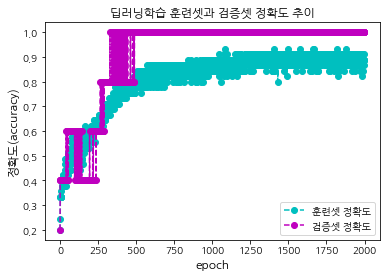

In [57]:
# 딥러닝학습 훈련셋과 검증셋 정확도 추이
plt.plot(x_len, y_acc, 'co--', label = '훈련셋 정확도')
plt.plot(x_len, y_vacc, 'mo--', label = '검증셋 정확도')
plt.title('딥러닝학습 훈련셋과 검증셋 정확도 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('정확도(accuracy)', size = 12)
plt.legend()

#### 훈련셋 딥러닝학습 오차과 정확도 추이

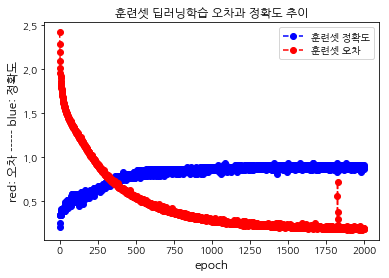

In [58]:
# 훈련셋 딥러닝학습 오차와 정확도 추이
plt.plot(x_len, y_acc, 'bo--', label = '훈련셋 정확도')
plt.plot(x_len, y_loss, 'ro--', label = '훈련셋 오차')
plt.title('훈련셋 딥러닝학습 오차과 정확도 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('red: 오차 ----- blue: 정확도', size = 12)
plt.legend()

# 마커설정 옵션 'bo--', 'ro--'
# --> color = 'blue', marker = 'o', linestyle = '--' 의미임
# --> color = 'red', marker = 'o', linestyle = '--' 의미임

#### 테스트셋 딥러닝학습 오차과 정확도 추이

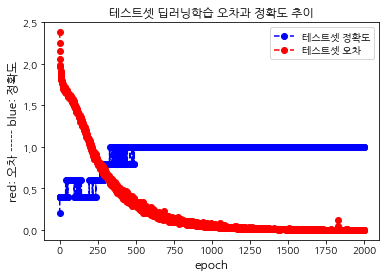

In [59]:
# 테스트셋 딥러닝학습 오차과 정확도 추이
plt.plot(x_len, y_vacc, 'bo--', label = '테스트셋 정확도')
plt.plot(x_len, y_vloss, 'ro--', label = '테스트셋 오차')
plt.title('테스트셋 딥러닝학습 오차과 정확도 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('red: 오차 ----- blue: 정확도', size = 12)
plt.legend()

#### 훈련셋 정확도와 검증셋 오차 추이
* 훈련셋의 정확도는 에포크(epoch)가 실행될 수록 좋아짐
* 반면에 검증셋의 오차는 에포크가 실행될 수록 더이상 좋아지지 않음
* 따라서 에포크(epoch) 회수를 통해 적정한 딥러닝 모델학습 지정이 필요함 
* 학습이 진행될수록 훈련셋의 정확도는 올라가지만, 
<br>과적합으로 인해 검증셋의 학습결과는 점점 나빠지게 됨
<img src = './images/train_validation.png'>

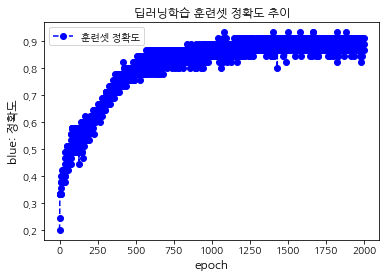

In [60]:
# 훈렷셋 딥러닝학습 정확도 추이
plt.plot(x_len, y_acc, color = 'blue', 
         marker = 'o', linestyle = '--', label = '훈련셋 정확도')
plt.title('딥러닝학습 훈련셋 정확도 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('blue: 정확도', size = 12)
plt.legend()

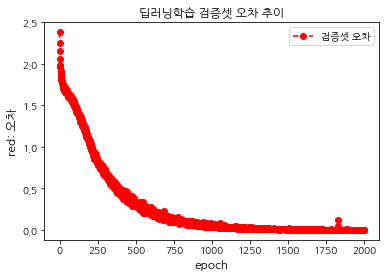

In [61]:
# 검증셋 딥러닝학습 오차 추이
plt.plot(x_len, y_vloss, color = 'red', 
         marker = 'o', linestyle = '--', label = '검증셋 오차')
plt.title('딥러닝학습 검증셋 오차 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('red: 오차', size = 12)
plt.legend()

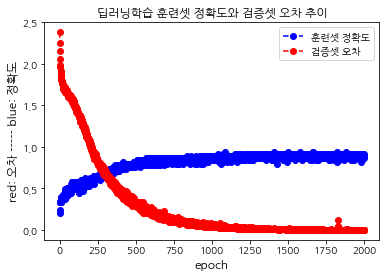

In [62]:
# 훈련셋 정확도와 검증셋 오차 추이
plt.plot(x_len, y_acc, color = 'blue', marker = 'o', 
         linestyle = '--', label = '훈련셋 정확도')
plt.plot(x_len, y_vloss, color = 'red', marker = 'o', 
         linestyle = '--', label = '검증셋 오차')
plt.title('딥러닝학습 훈련셋 정확도와 검증셋 오차 추이')
plt.xlabel('epoch', size = 12)
plt.ylabel('red: 오차 ----- blue: 정확도', size = 12)
plt.legend()

# 마커설정 옵션: color = 'red', marker = 'o', linestyle = '--'
# --> 'ro--'로 축약해서 설정가능함

### 모델 성능평가

#### 훈련셋(train) 성능평가

In [63]:
# 훈련셋을 활용한 딥러닝모델의 성능평가 결과
train_perf = md.evaluate(X_train_scaled, y_train_ohe)
train_perf

50/50 [==============================] - 0s 100us/step


[0.14946425557136536, 0.9200000023841858]

In [64]:
print('훈련셋 모델성능 종합:', [round(i, 3) for i in train_perf])
print(f'훈련셋 모델성능       오차(loss): {train_perf[0]:0.3f}')
print(f'훈련셋 모델성능 정확도(accuracy): {train_perf[1]:0.3f}')

훈련셋 모델성능 종합: [0.149, 0.92]
훈련셋 모델성능       오차(loss): 0.149
훈련셋 모델성능 정확도(accuracy): 0.920


# <font color = 'blue'>딥러닝 모델 예측하기</font>

### 한 스텝(윈도우)씩 실제 음표값을 투입해 음표를 예측
* 실제 음표 4개를 입력해서 그 다음 음표 1개를 예측하는 과정을 반복하는 방법
* 준비된 윈도우 길이만큼의 음표 4개 조합이 계속적으로 추가 입력되어 그 다음 음표를 예측하는 과정을 반복하게됨
* 최초로 투입되는 4개 음표 이후에, 이어지는 전체 노래의 음표들을 모두 예측하지만,
<br>각 음표 예측을 위해 실제 음표 4개 조합이 계속 추가 투입되어 활용됨
<img src = './images/music_onestep.png'>

#### 음표 예측 실시

In [65]:
# 음표시퀀스 출력결과 저장용 리스트객체 생성
seq_out = ['g8', 'e8', 'e4', 'f8']
# - 최초 투입되는 4개 음표는 미리 지정해 놓음
# - 이 4개 음표 이후로 예측되는 음표들이 추가저장될 예정임

# 최대 예측 음표개수 정의
pred_count = 50
# - 최초 투입되는 4개 음표 이후로 50개 정도의 음표를 예측할 수 있도록 지정함

In [66]:
# 음표 예측실시
pred_out = md.predict(X_train_scaled)
pred_out
# - 4개 윈도우 길이에 해당하는 음표를 투입해 이후로 이어지는 음표를 반복예측실시함
# - 4개 윈도우 길이 음표를 입력할 때마다 원핫인코딩방식으로 12개 음표 인덱스번호에 대한 확률값이 예측됨 
# - 이 확률값 중에서 가장 수치가 높은 레이블이 1로 기록되어 음표 인덱스번호로 기록됨

array([[3.21930145e-13, 0.00000000e+00, 1.73314207e-17, 1.02312027e-10,
        3.99712823e-24, 3.34738239e-14, 1.43257286e-13, 5.12586064e-16,
        9.94953215e-01, 5.04675694e-03, 4.35769856e-14, 0.00000000e+00],
       [7.23221504e-13, 9.98334467e-01, 2.78844873e-05, 1.74295463e-12,
        6.52133512e-17, 5.29939265e-13, 1.61388611e-12, 1.40056291e-26,
        2.45241954e-05, 1.61324802e-03, 1.45483356e-11, 9.40051734e-15],
       [4.38977222e-20, 0.00000000e+00, 0.00000000e+00, 1.02477499e-29,
        0.00000000e+00, 3.34974570e-19, 9.04116084e-22, 9.99986053e-01,
        7.05594640e-14, 5.81548102e-20, 1.39217536e-05, 0.00000000e+00],
       [2.38411148e-11, 0.00000000e+00, 2.31751788e-11, 1.13504236e-14,
        1.19477125e-29, 4.44804079e-13, 9.93684475e-12, 3.10457250e-11,
        3.02034914e-01, 6.97965086e-01, 1.27726443e-12, 0.00000000e+00],
       [2.29738384e-09, 1.32522677e-04, 3.03682216e-14, 2.49211553e-07,
        1.04185298e-14, 1.51056290e-09, 2.38803555e-09, 8.33

In [67]:
for i in range(pred_count): 
    # - 앞서 입력한대로 50번정도 for구문을 통해 반복 예측실시함
    
    idx = np.argmax(pred_out[i])
    # - 4개 음표 인덱스번호가 입력되어 12개 음표레이블에 대한 확률값이 나타나고
    #   각 확률값 수치중에서 가장 숫자가 큰 위치를 argmax()로 확인해 정수레이블로 만듬 
    
    seq_out.append(idx2code[idx])
    # - 가장 확률값 수치가 큰 위치를 이용해 음표인덱스2음표코드 사전을 이용해 음표로 변환시킴 
    
print('한 스텝(윈도우)씩 실제 음표값을 투입해 전체노래를 예측:\n', seq_out)

한 스텝(윈도우)씩 실제 음표값을 투입해 전체노래를 예측:
 ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


#### 음표 예측 결과 비교

In [68]:
# 실제 노래음표와 예측음표간 비교용 리스트객체 생성
seq_compare = []

# for반복구문을 이용한 음표 하나하나 비교
for i in range(len(seq)):
    if seq[i] == seq_out[i]:
        seq_compare.append('일치')
    else:
        seq_compare.append('불일치')

seq_compare

['일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '불일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '불일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '불일치',
 '일치',
 '불일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치']

In [69]:
# 실제 노래음표와 예측음표간 비교테이블 생성
result = pd.DataFrame({'원곡 음표': seq,
                       '예측 음표': seq_out, 
                       '비교 결과': seq_compare})
result

,원곡 음표,예측 음표,비교 결과
0,g8,g8,일치
1,e8,e8,일치
2,e4,e4,일치
3,f8,f8,일치
4,d8,d8,일치
5,d4,d4,일치
6,c8,c8,일치
7,d8,e8,불일치
8,e8,e8,일치
9,f8,f8,일치


In [70]:
# 실제 노래음표와 예측음표간 비교결과
result_labelcount = {k: v for k, v in zip(result['비교 결과'].unique(), result['비교 결과'].value_counts())}
print(type(result_labelcount))
print(result_labelcount.keys())
print(result_labelcount.values())
print(result_labelcount.items())
print()

for k, v in result_labelcount.items(): 
    pct = v / sum(result_labelcount.values()) 
    print(f"레이블: {k:}, 빈도수: {v}, 비율: {pct:0.3f}") 

<class 'dict'>
dict_keys(['일치', '불일치'])
dict_values([50, 4])
dict_items([('일치', 50), ('불일치', 4)])

레이블: 일치, 빈도수: 50, 비율: 0.926
레이블: 불일치, 빈도수: 4, 비율: 0.074


### 최초 4개 음표를 투입해 나머지 노래전체를 예측
* 최초 음표 4개만을 입력해서 그 다음 음표들을 계속 예측해 나가는 방법
* 실제 윈도우 길이에 해당하는 음표 4개가 계속 추가입력되는 것이 아니라, 
<br>예측된 음표값이 입력값으로 활용되어 예측이 이어지는 구조임
* 예측된 음표값이 틀리게 되면 이후 음정과 박자가 이상하게 표시되는 예측오류 누적가능성이 큼
<img src = './images/music_fullstep.png'>

#### 음표 예측 실시

In [71]:
# 음표시퀀스 출력결과 저장용 리스트객체 생성
seq_out = ['g8', 'e8', 'e4', 'f8']
# - 최초 투입되는 4개 음표는 미리 지정해 놓음
# - 이 4개 음표 이후로 예측되는 음표들이 추가저장될 예정임

# 최대 예측 음표개수 정의
pred_count = 50
# - 최초 투입되는 4개 음표 이후로 50개 정도의 음표를 예측할 수 있도록 지정함

In [72]:
# 최초 투입되는 4개음표를 음표 인덱스번호로 변환해서 투입함
seq_in = [code2idx[i] for i in seq_out]
print(seq_in)

seq_in_scaled = np.array(seq_in) / float(np.max(X_train))
print(seq_in_scaled)

[11, 9, 2, 10]
[1.         0.81818182 0.18181818 0.90909091]


In [73]:
# 음표 예측실시
for i in range(pred_count):
    # - 앞서 입력한대로 50번정도 for구문을 통해 반복 예측실시함
    
    sample_in = np.reshape(seq_in_scaled, (1, 4))
    # - 4개 음표를 입력피처셋으로 만들기 위한 넘파이 배열 재구조화
    
    pred_out = md.predict(sample_in)
    # - 4개 윈도우 길이에 해당하는 음표를 투입해 이후로 이어지는 음표를 반복예측실시함
    # - 4개 윈도우 길이 음표를 입력할 때마다 원핫인코딩방식으로 12개 음표 인덱스번호에 대한 확률값이 예측됨 
    # - 이 확률값 중에서 가장 수치가 높은 레이블이 1로 기록되어 음표 인덱스번호로 기록됨

    idx = np.argmax(pred_out)
    # - 4개 음표 인덱스번호가 입력되어 12개 음표레이블에 대한 확률값이 나타나고
    #   각 확률값 수치중에서 가장 숫자가 큰 위치를 argmax()로 확인해 정수레이블로 만듬 

    seq_out.append(idx2code[idx])
    # - 가장 확률값 수치가 큰 위치를 이용해 음표인덱스2음표코드 사전을 이용해 음표로 변환시킴
    
    seq_in.append(idx / float(np.max(X_train)))
    # - 예측한 정수 레이블을 스케일링실시해 다시 음표예측용 입력윈도우에 추가반영함

    seq_in.pop(0)
    # - 바로 위 코드에서 새로 예측된 음표예측용 정수 레이블이 추가되었으므로 
    #   기존에 있던 음표예측욕 정수 레이블을 한개 제거시킴
    
print('최초 4개 음표를 투입해 나머지 노래전체를 예측:\n', seq_out)

최초 4개 음표를 투입해 나머지 노래전체를 예측:
 ['g8', 'e8', 'e4', 'f8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8']


#### 음표 예측 결과 비교

In [74]:
# 실제 노래음표와 예측음표간 비교용 리스트객체 생성
seq_compare = []

# for반복구문을 이용한 음표 하나하나 비교
for i in range(len(seq)):
    if seq[i] == seq_out[i]:
        seq_compare.append('일치')
    else:
        seq_compare.append('불일치')

seq_compare

['일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '불일치',
 '불일치',
 '일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치',
 '불일치']

In [75]:
# 실제 노래음표와 예측음표간 비교테이블 생성
result = pd.DataFrame({'원곡 음표': seq,
                       '예측 음표': seq_out, 
                       '비교 결과': seq_compare})
result

,원곡 음표,예측 음표,비교 결과
0,g8,g8,일치
1,e8,e8,일치
2,e4,e4,일치
3,f8,f8,일치
4,d8,d8,일치
5,d4,d8,불일치
6,c8,d8,불일치
7,d8,d8,일치
8,e8,d8,불일치
9,f8,d8,불일치


In [76]:
result['비교 결과'].unique()

array(['일치', '불일치'], dtype=object)

In [77]:
result['비교 결과'].value_counts()

불일치    41
일치     13
Name: 비교 결과, dtype: int64

In [78]:
# 실제 노래음표와 예측음표간 비교결과
result_labelcount = {k: v for k, v in zip(result['비교 결과'].unique(), result['비교 결과'].value_counts(ascending = True))}
print(type(result_labelcount))
print(result_labelcount.keys())
print(result_labelcount.values())
print(result_labelcount.items())
print()

for k, v in result_labelcount.items(): 
    pct = v / sum(result_labelcount.values()) 
    print(f"레이블: {k:}, 빈도수: {v}, 비율: {pct:0.3f}") 

<class 'dict'>
dict_keys(['일치', '불일치'])
dict_values([13, 41])
dict_items([('일치', 13), ('불일치', 41)])

레이블: 일치, 빈도수: 13, 비율: 0.241
레이블: 불일치, 빈도수: 41, 비율: 0.759


# End of Source